In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import itertools
import matplotlib.colors as mcolors

from scipy.integrate import quad
from matplotlib.patches import Polygon
from matplotlib.patches import ConnectionPatch
from scipy.integrate import quad

sns.set(style="dark", color_codes=True)

Data Source:  
Original data is US Environmental Protection Agency (EPA) published fuel 
economy data.  

https://www.fueleconomy.gov/feg/download.shtml

I prepared the data by keeping only columns of interest for this 
presentation and added a fictitious car company and model for the 
purpose of discussing outliers in data.

In [2]:
# data source:  https://www.fueleconomy.gov/feg/download.shtml
# The data files are subsets of columns from the full 2021 EPA data 
data = pd.read_csv("./data/2021_EPA_MPG.csv")
data_o = pd.read_csv("./data/2021_EPA_MPG_w_Outlier.csv")
data_8cyl = data[data.cyl==8]
data_o_8cyl = data_o[data_o.cyl==8]

In [3]:
# Using combined adjusted MPG for this discussion.  Dropping unadjusted.
data.rename(columns={"mpg_adj_comb":"MPG"}, inplace=True)
data.drop("mpg_unadj_comb", axis=1, inplace=True)

data_o.rename(columns={"mpg_adj_comb":"MPG"}, inplace=True)
data_o.drop("mpg_unadj_comb", axis=1, inplace=True)

In [4]:
# Import stats library
import scipy.stats as stats
# Add z-score stat based on MPG rating
data["MPG_zscore"] = stats.zscore(data.MPG)
data_o["MPG_zscore"] = stats.zscore(data_o.MPG)
# For coloring charts, create an indicator of when z-score is beyond 3 std deviations
data["zscore_outlier"] = data.apply(lambda row: True if abs(row.MPG_zscore) >= 3 else False, axis=1)
data_o["zscore_outlier"] = data_o.apply(lambda row: True if abs(row.MPG_zscore) >= 3 else False, axis=1)

In [5]:
# Calculate IQR values on base dataset
q1, q3 = np.percentile(data.MPG, [25,75])
iqr = q3-q1
lower_limit = q1 - (1.5*iqr)
upper_limit = q3 + (1.5*iqr)
print(f'Q1 = {q1},  Q3 = {q3}')
print(f'Interquartile Range: {iqr},  Q1-1.5IQR = {lower_limit},  Q3+1.5IQR = {upper_limit}')

# create outlier indicator based on 1.5*IQR indicator column
data["iqr_outlier"] = data.apply(lambda row: True if (row.MPG > upper_limit) or (row.MPG < lower_limit) else False, axis=1)

Q1 = 18.0,  Q3 = 26.0
Interquartile Range: 8.0,  Q1-1.5IQR = 6.0,  Q3+1.5IQR = 38.0


In [6]:
data.head()

,year,mfr_name,division,model,cyl,displ,MPG,MPG_zscore,zscore_outlier,iqr_outlier
0,2021,Honda,Acura,NSX,6,3.5,21,-0.309177,False,False
1,2021,aston martin,Aston Martin Lagonda Ltd,Vantage Manual,8,4.0,17,-0.932861,False,False
2,2021,aston martin,Aston Martin Lagonda Ltd,Vantage V8,8,4.0,20,-0.465098,False,False
3,2021,Volkswagen Group of,Audi,R8,10,5.2,16,-1.088782,False,False
4,2021,Volkswagen Group of,Audi,R8 2WD,10,5.2,17,-0.932861,False,False


In [7]:
data_o.head()

,year,mfr_name,division,model,cyl,displ,MPG,MPG_zscore,zscore_outlier
0,2021,Wishful Thinkin,Wishful,Fast and Efficient,8,5.2,170,19.036747,True
1,2021,Honda,Acura,NSX,6,3.5,21,-0.273250,False
2,2021,aston martin,Aston Martin Lagonda Ltd,Vantage Manual,8,4.0,17,-0.791639,False
3,2021,aston martin,Aston Martin Lagonda Ltd,Vantage V8,8,4.0,20,-0.402847,False
4,2021,Volkswagen Group of,Audi,R8,10,5.2,16,-0.921236,False


In [8]:
# Take a look at the outliers as identified by MPG z-score
data[data.zscore_outlier ==True]

,year,mfr_name,division,model,cyl,displ,MPG,MPG_zscore,zscore_outlier,iqr_outlier
245,2021,Honda,Honda,INSIGHT TOURING,4,1.5,48,3.900690,True,True
310,2021,Toyota,TOYOTA,COROLLA HYBRID,4,1.8,52,4.524374,True,True
378,2021,Honda,Honda,INSIGHT,4,1.5,52,4.524374,True,True
383,2021,Hyundai,HYUNDAI MOTOR COMPANY,Elantra Hybrid,4,1.6,50,4.212532,True,True
384,2021,Hyundai,HYUNDAI MOTOR COMPANY,Elantra Hybrid Blue,4,1.6,54,4.836216,True,True
400,2021,Toyota,LEXUS,ES 300h,4,2.5,44,3.277006,True,True
449,2021,Toyota,TOYOTA,AVALON HYBRID,4,2.5,43,3.121085,True,True
450,2021,Toyota,TOYOTA,AVALON HYBRID XLE,4,2.5,44,3.277006,True,True
456,2021,Toyota,TOYOTA,CAMRY HYBRID LE,4,2.5,52,4.524374,True,True
457,2021,Toyota,TOYOTA,CAMRY HYBRID SE/XLE/XSE,4,2.5,46,3.588848,True,True


In [9]:
# Import numpy for percentile calculation
import numpy as np
# Calculate IQR values on dataset with fictitious outlier added
q1, q3 = np.percentile(data_o.MPG, [25,75])
iqr = q3-q1
lower_limit = q1 - (1.5*iqr)
upper_limit = q3 + (1.5*iqr)
print(f'Q1 = {q1},  Q3 = {q3}')
print(f'Interquartile Range: {iqr},  Q1-1.5IQR = {lower_limit},  Q3+1.5IQR = {upper_limit}')
# create outlier indicator based on 1.5*IQR indicator column
data_o["iqr_outlier"] = data_o.apply(lambda row: True if (row.MPG > upper_limit) or (row.MPG < lower_limit) else False, axis=1)

Q1 = 18.0,  Q3 = 26.0
Interquartile Range: 8.0,  Q1-1.5IQR = 6.0,  Q3+1.5IQR = 38.0


In [10]:
data_o.head()

,year,mfr_name,division,model,cyl,displ,MPG,MPG_zscore,zscore_outlier,iqr_outlier
0,2021,Wishful Thinkin,Wishful,Fast and Efficient,8,5.2,170,19.036747,True,True
1,2021,Honda,Acura,NSX,6,3.5,21,-0.273250,False,False
2,2021,aston martin,Aston Martin Lagonda Ltd,Vantage Manual,8,4.0,17,-0.791639,False,False
3,2021,aston martin,Aston Martin Lagonda Ltd,Vantage V8,8,4.0,20,-0.402847,False,False
4,2021,Volkswagen Group of,Audi,R8,10,5.2,16,-0.921236,False,False


Slide 7 of presentation

In [11]:
data[["cyl","displ","MPG"]].describe().round(2)

,cyl,displ,MPG
count,1170.00,1170.00,1170.00
mean,5.67,3.19,22.98
std,1.92,1.37,6.42
min,3.00,1.00,10.00
25%,4.00,2.00,18.00
50%,6.00,3.00,22.00
75%,6.00,4.00,26.00
max,16.00,8.00,59.00


In [12]:
data_o[["cyl","displ","MPG"]].describe().round(2)

,cyl,displ,MPG
count,1171.00,1171.00,1171.00
mean,5.68,3.19,23.11
std,1.92,1.37,7.72
min,3.00,1.00,10.00
25%,4.00,2.00,18.00
50%,6.00,3.00,22.00
75%,6.00,4.00,26.00
max,16.00,8.00,170.00


In [13]:
# Summary stats grouped by cylinder count not used in presentation
data[["cyl","displ","MPG"]].groupby("cyl").describe().round(2)

displ                                           MPG                     \
     count  mean   std  min   25%  50%   75%  max  count   mean   std   min   
cyl                                                                           
3     26.0  1.38  0.15  1.0  1.23  1.5  1.50  1.5   26.0  30.92  3.12  26.0   
4    503.0  2.08  0.32  1.3  2.00  2.0  2.40  2.8  503.0  27.47  6.30  17.0   
5      1.0  2.50   NaN  2.5  2.50  2.5  2.50  2.5    1.0  24.00   NaN  24.0   
6    350.0  3.28  0.35  2.7  3.00  3.0  3.50  4.3  350.0  21.18  2.64  14.0   
8    257.0  5.05  0.83  3.8  4.00  5.3  5.70  6.4  257.0  17.00  1.57  12.0   
10     8.0  5.20  0.00  5.2  5.20  5.2  5.20  5.2    8.0  15.75  0.89  15.0   
12    23.0  6.37  0.44  5.2  6.25  6.5  6.65  6.7   23.0  13.74  2.09  10.0   
16     2.0  8.00  0.00  8.0  8.00  8.0  8.00  8.0    2.0  10.50  0.71  10.0   

                               
       25%   50%    75%   max  
cyl                            
3    29.00  30.5  32.00  39.0  
4    24.00  26.0  29.00  59.0  
5    24.00  24.0  24.00  24.0  
6    20.00  21.0  23.00  30.0  
8    16.00  17.0  18.00  21.0  
10   15.00  15.5  16.25  17.0  
12   13.50  14.0  14.50  18.0  
16   10.25  10.5  10.75  11.0

Text(0.5, 1.0, 'Extreme Outlier Added')

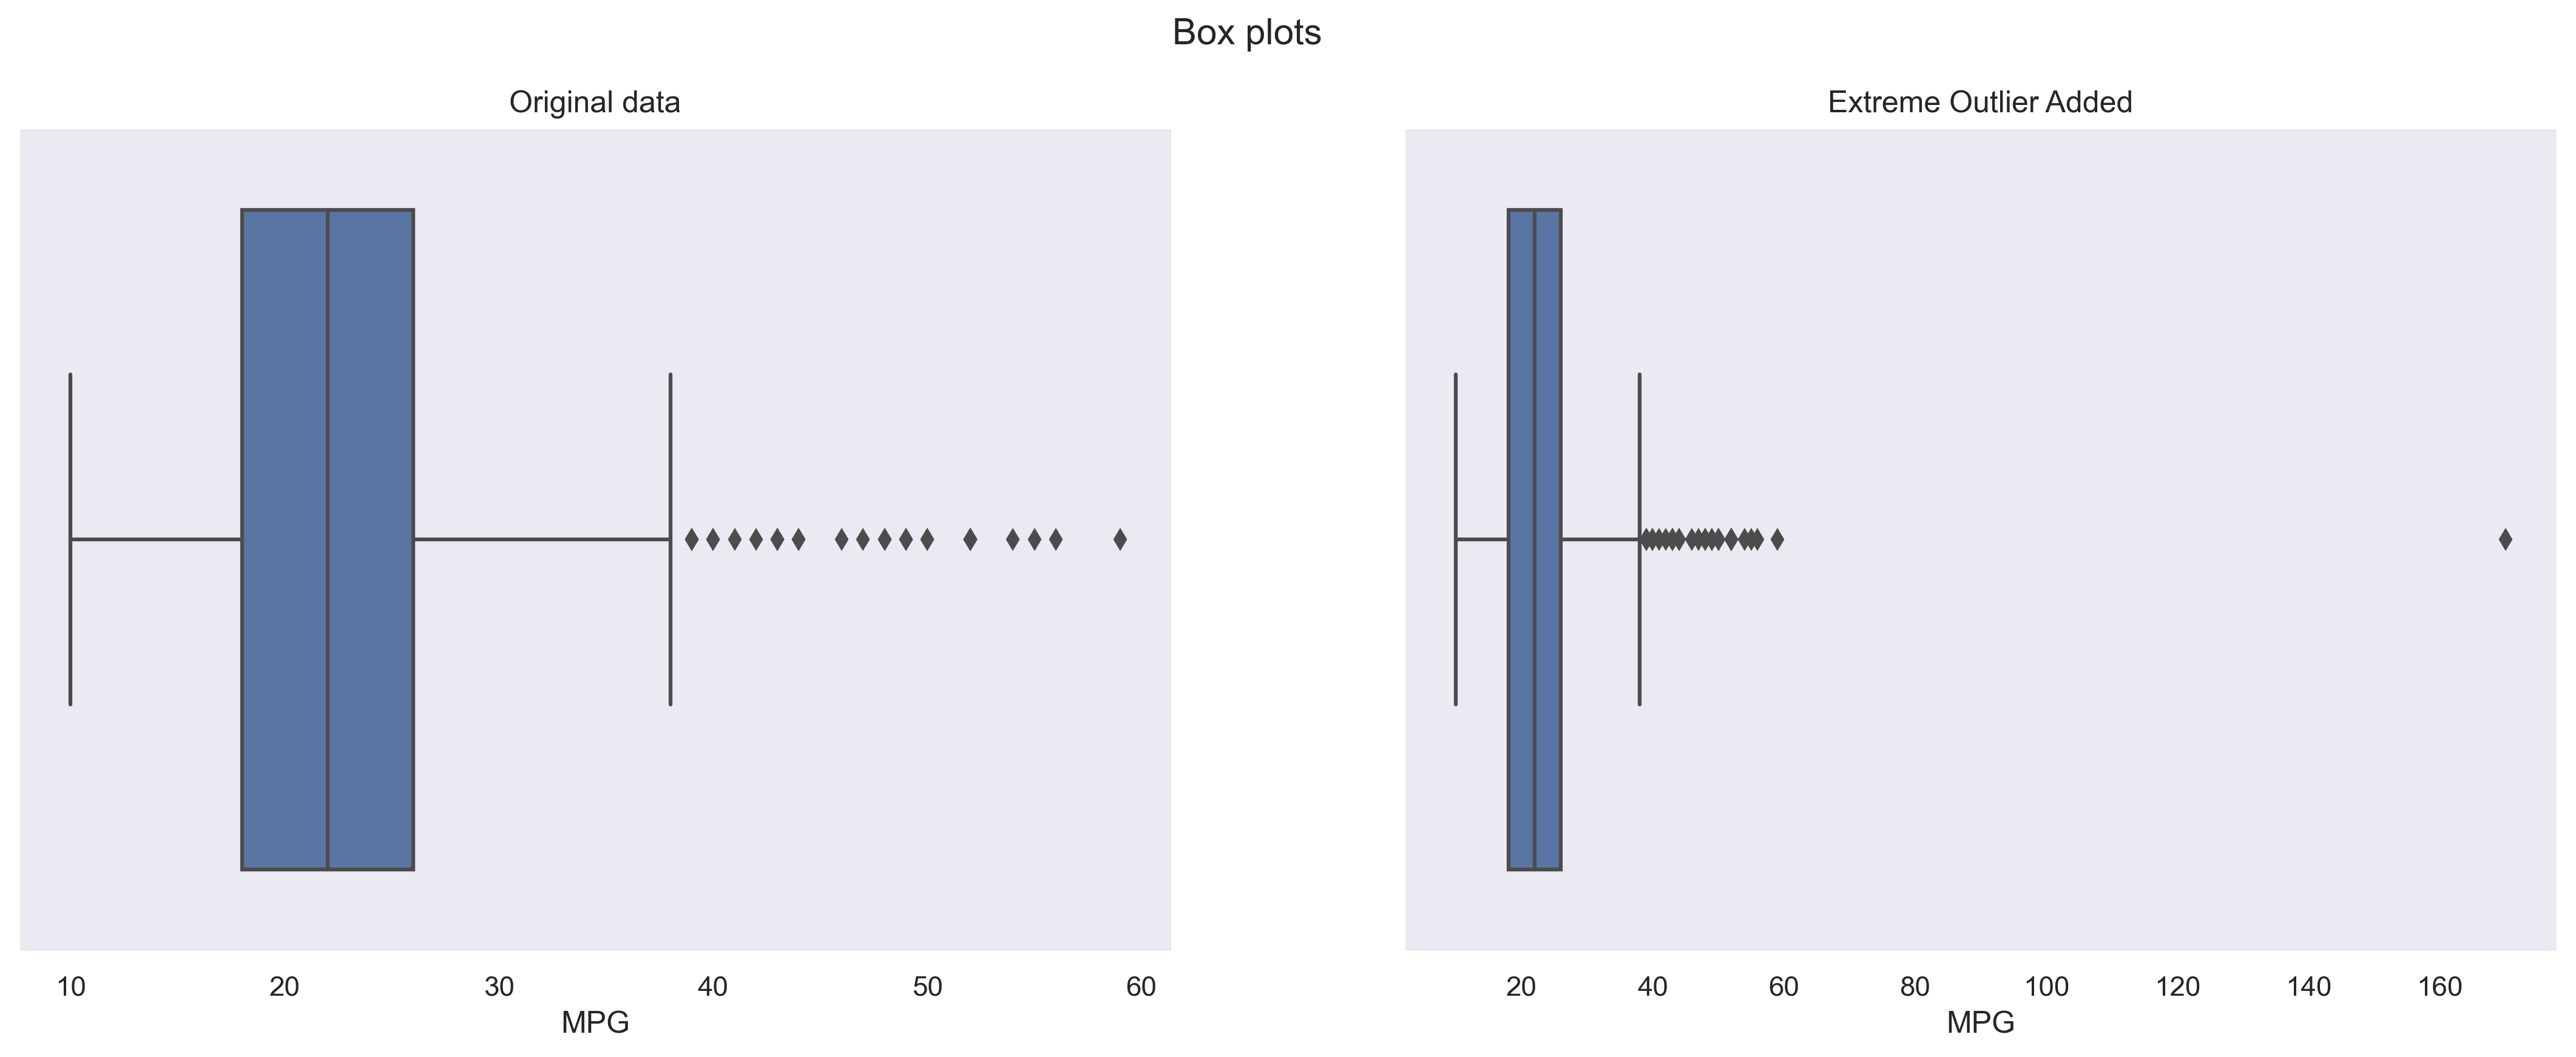

In [14]:
# Box Plots
fig, (ax1, ax2) = plt.subplots(
    nrows=1, 
    ncols=2, 
    figsize=(18,6), 
    dpi=300, sharey=True)
fig.suptitle('Box plots')
sns.boxplot(
    data=data, 
    x="MPG", 
    ax=ax1)
ax1.set_title("Original data")
sns.boxplot(data=data_o, x="MPG", ax=ax2)
ax2.set_title("Extreme Outlier Added")


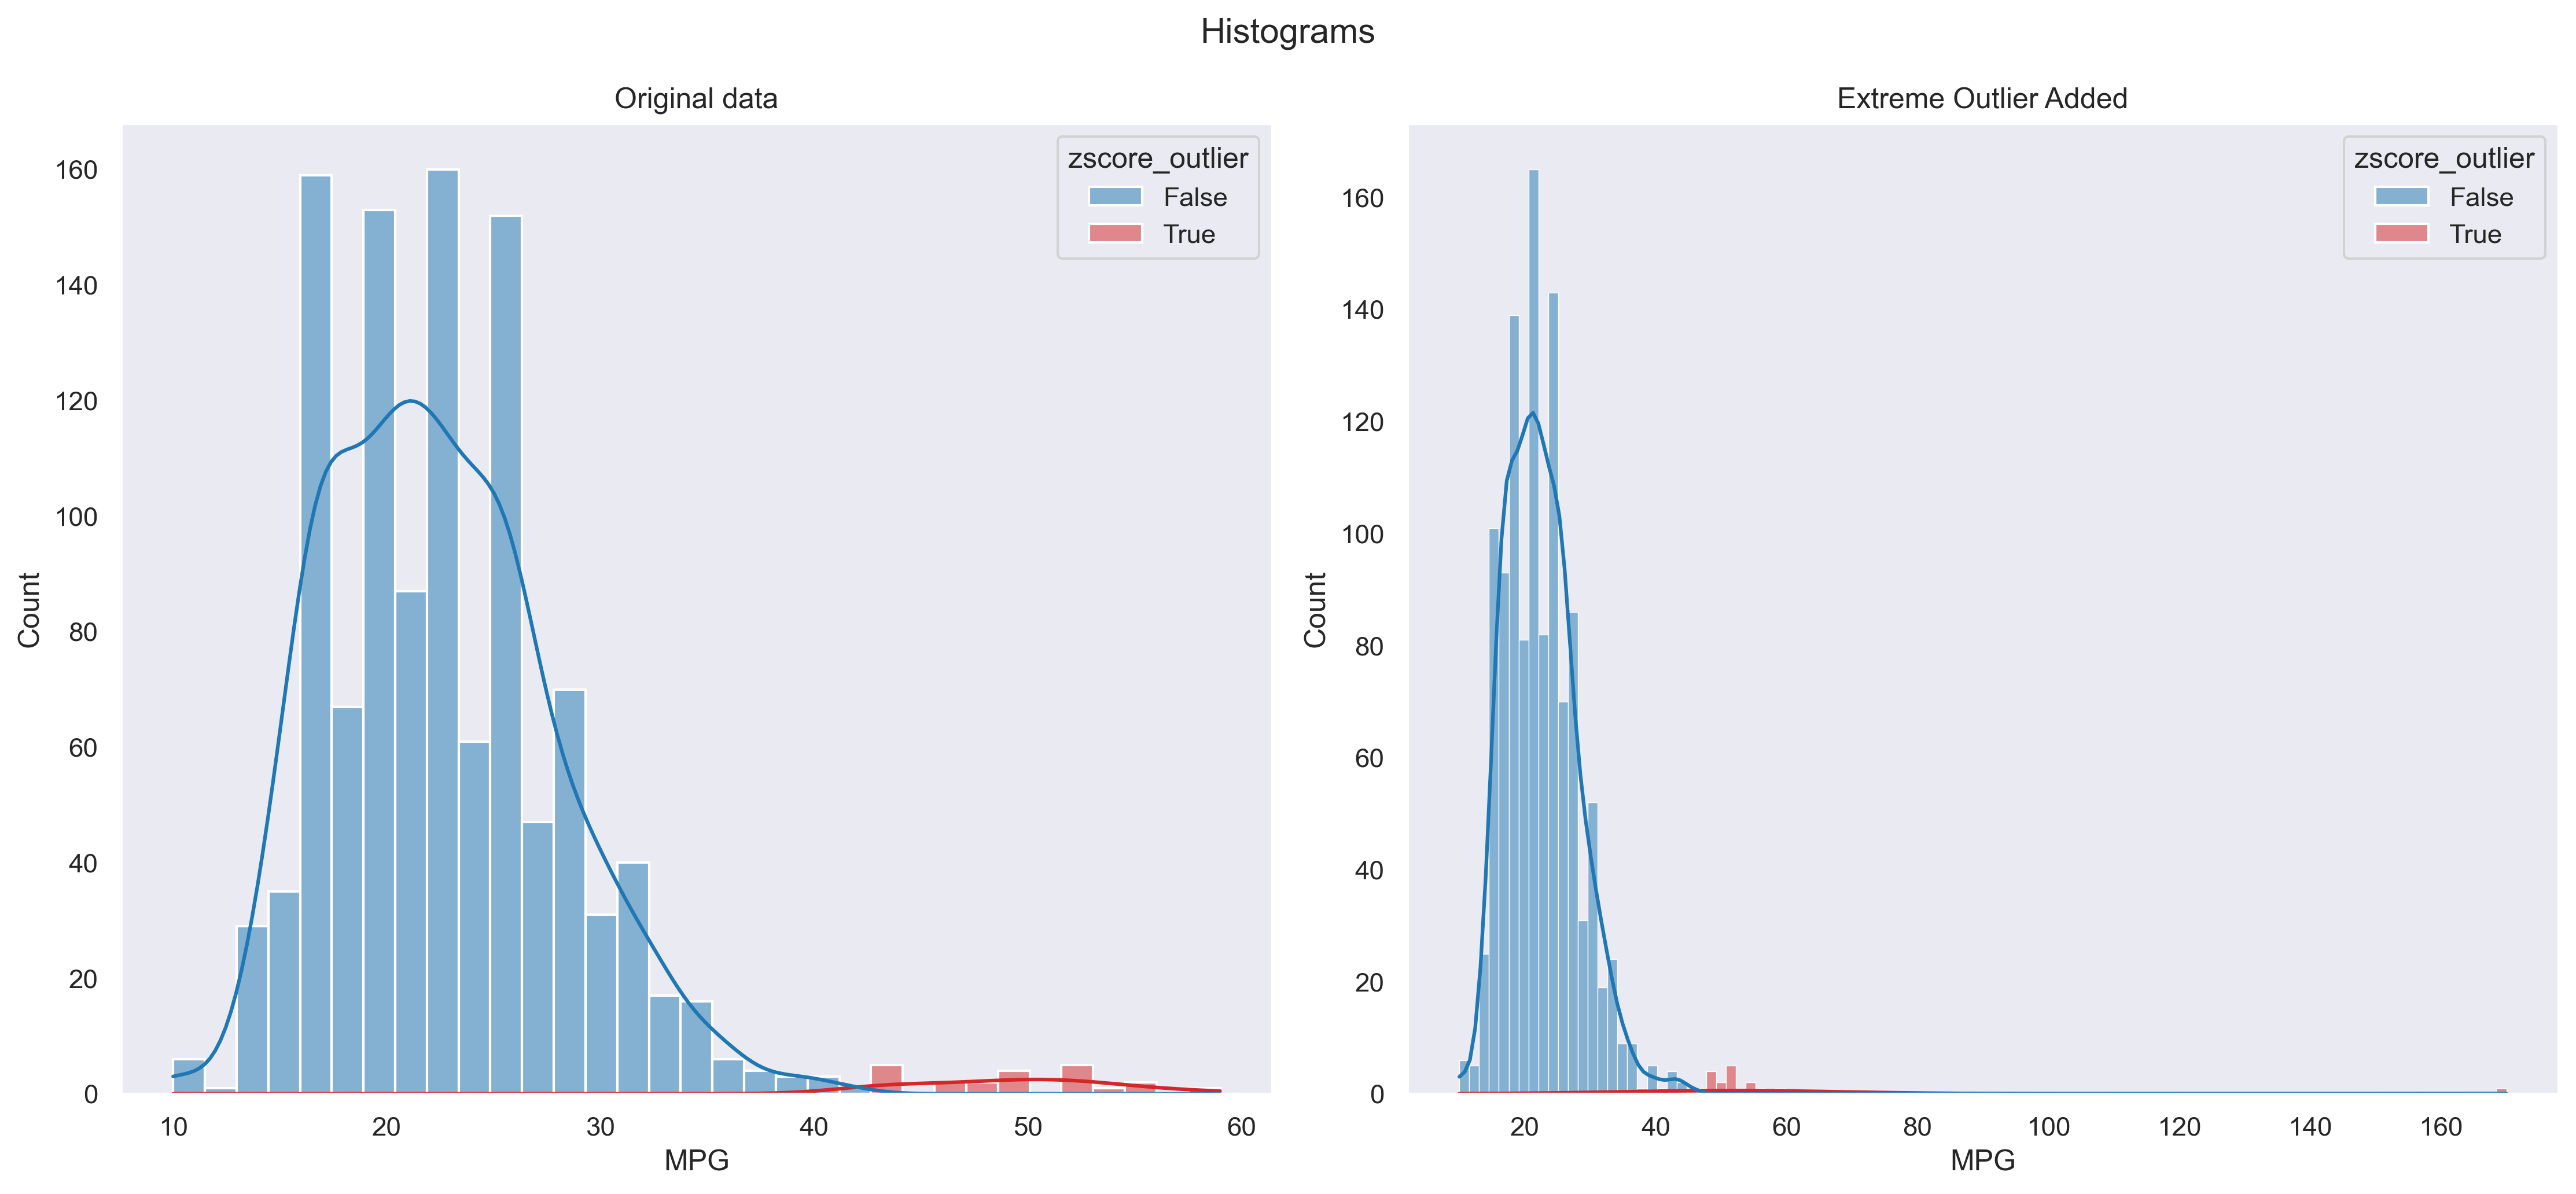

In [15]:
# Histograms
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,7), dpi=300)
fig.suptitle('Histograms')
# set palette 
palette = {False:"tab:blue",
           True:"tab:red"}
sns.histplot(
    data=data, 
    x="MPG", 
    ax=ax1, 
    palette=palette, 
    hue=data.zscore_outlier, 
    kde=True)
ax1.set_title("Original data")
sns.histplot(data=data_o, x="MPG", ax=ax2, palette=palette, hue=data_o.zscore_outlier, kde=True)
ax2.set_title("Extreme Outlier Added")
plt.tight_layout()

Text(0.5, 1.0, 'Extreme Outlier Added')

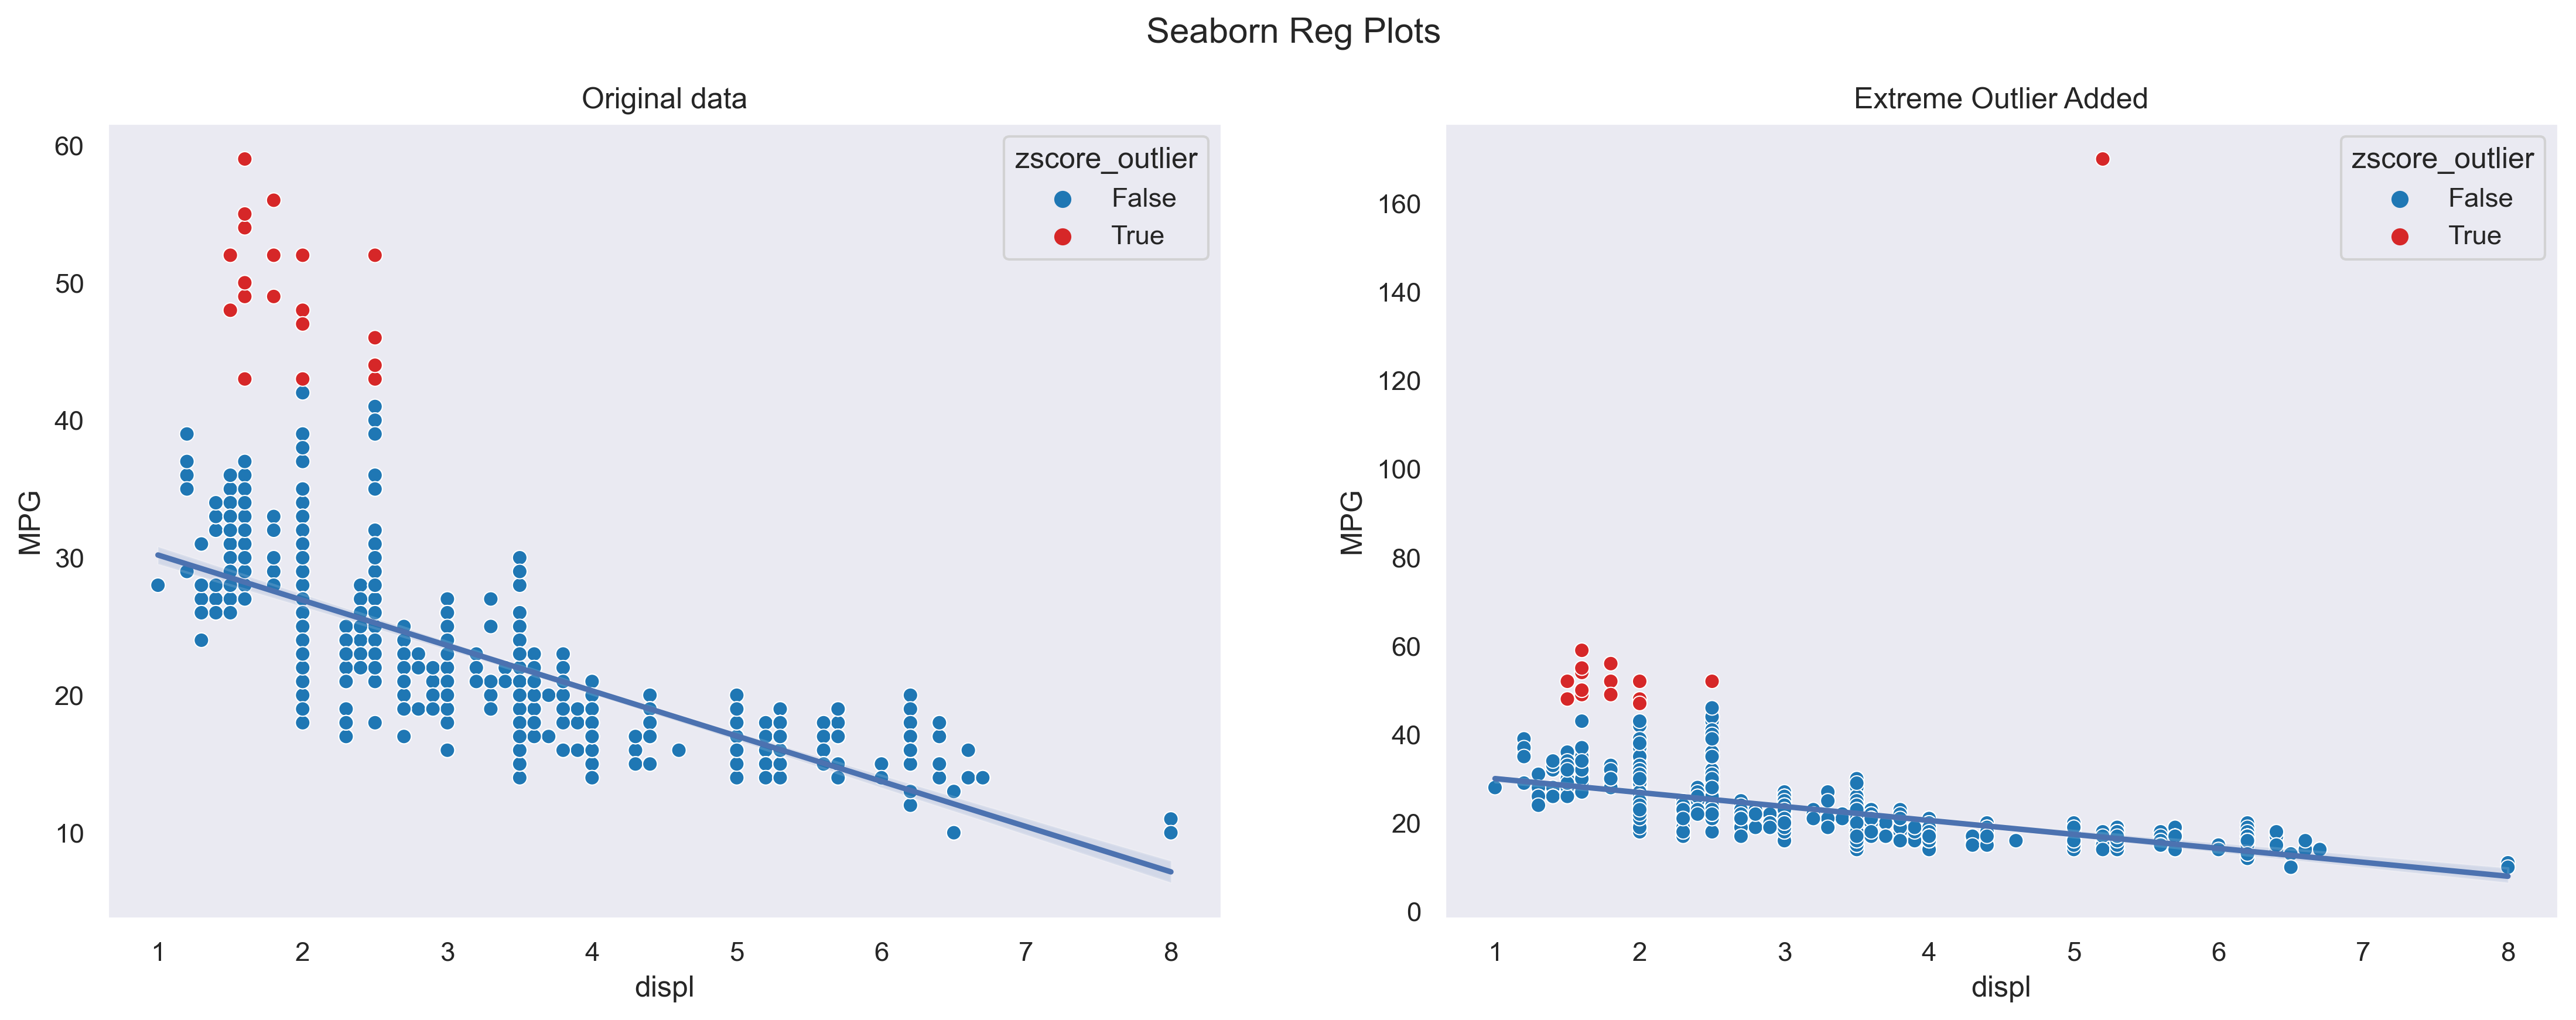

In [16]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,6), dpi=300)
fig.suptitle('Seaborn Reg Plots')
# set palette 
palette = {False:"tab:blue",
           True:"tab:red"}
sns.scatterplot(
    data=data, 
    x="displ", 
    y="MPG", 
    ax=ax1, 
    palette=palette, 
    hue=data.zscore_outlier)
sns.regplot(
    data=data, 
    x="displ", 
    y="MPG", 
    ax=ax1, 
    scatter=False)
ax1.set_title("Original data")

sns.scatterplot(data=data_o, x="displ", y="MPG", ax=ax2, palette=palette, hue=data_o.zscore_outlier)
sns.regplot(data=data_o, x="displ", y="MPG", ax=ax2, scatter=False)
ax2.set_title("Extreme Outlier Added")

In [17]:
data_removed = data[data.zscore_outlier==False]
data_o_removed = data_o[data_o.zscore_outlier==False]
data_outliers = data[data.zscore_outlier==True]
data_o_outliers = data_o[data_o.zscore_outlier==True]

Text(0.5, 1.0, 'Original data - Outliers removed')

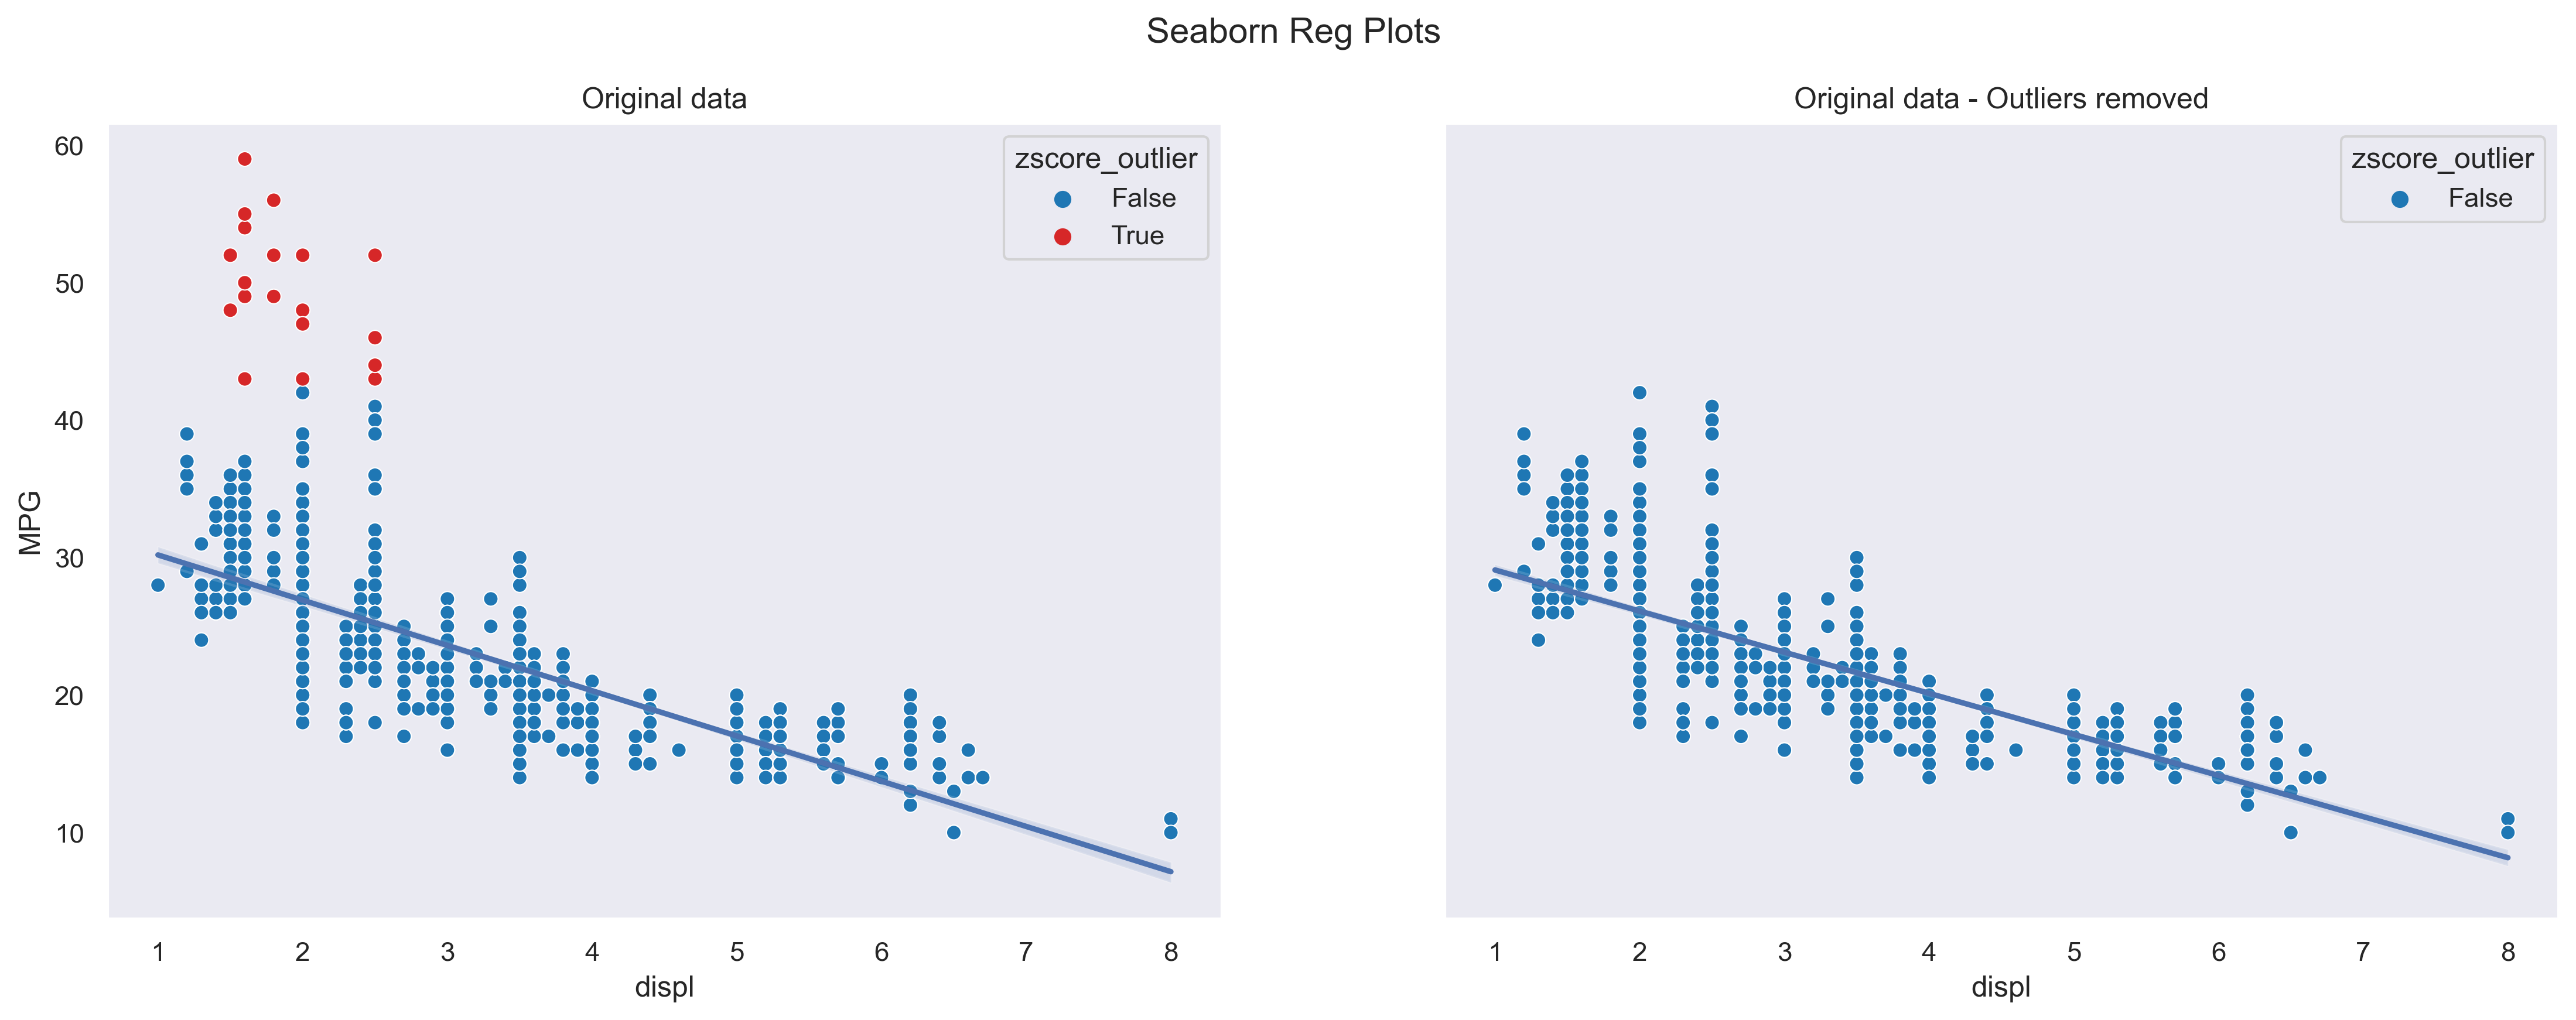

In [18]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,6), dpi=300, sharey=True)
fig.suptitle('Seaborn Reg Plots')
# set palette 
palette = {False:"tab:blue",
           True:"tab:red"}

sns.scatterplot(data=data, x="displ", y="MPG", ax=ax1, palette=palette, hue=data.zscore_outlier)
sns.regplot(data=data, x="displ", y="MPG", ax=ax1, scatter=False)
ax1.set_title("Original data")

sns.scatterplot(data=data_removed, x="displ", y="MPG", ax=ax2, palette=palette, hue=data_removed.zscore_outlier)
sns.regplot(data=data_removed, x="displ", y="MPG", ax=ax2, scatter=False)
ax2.set_title("Original data - Outliers removed")

Text(0.5, 1.0, 'Original data')

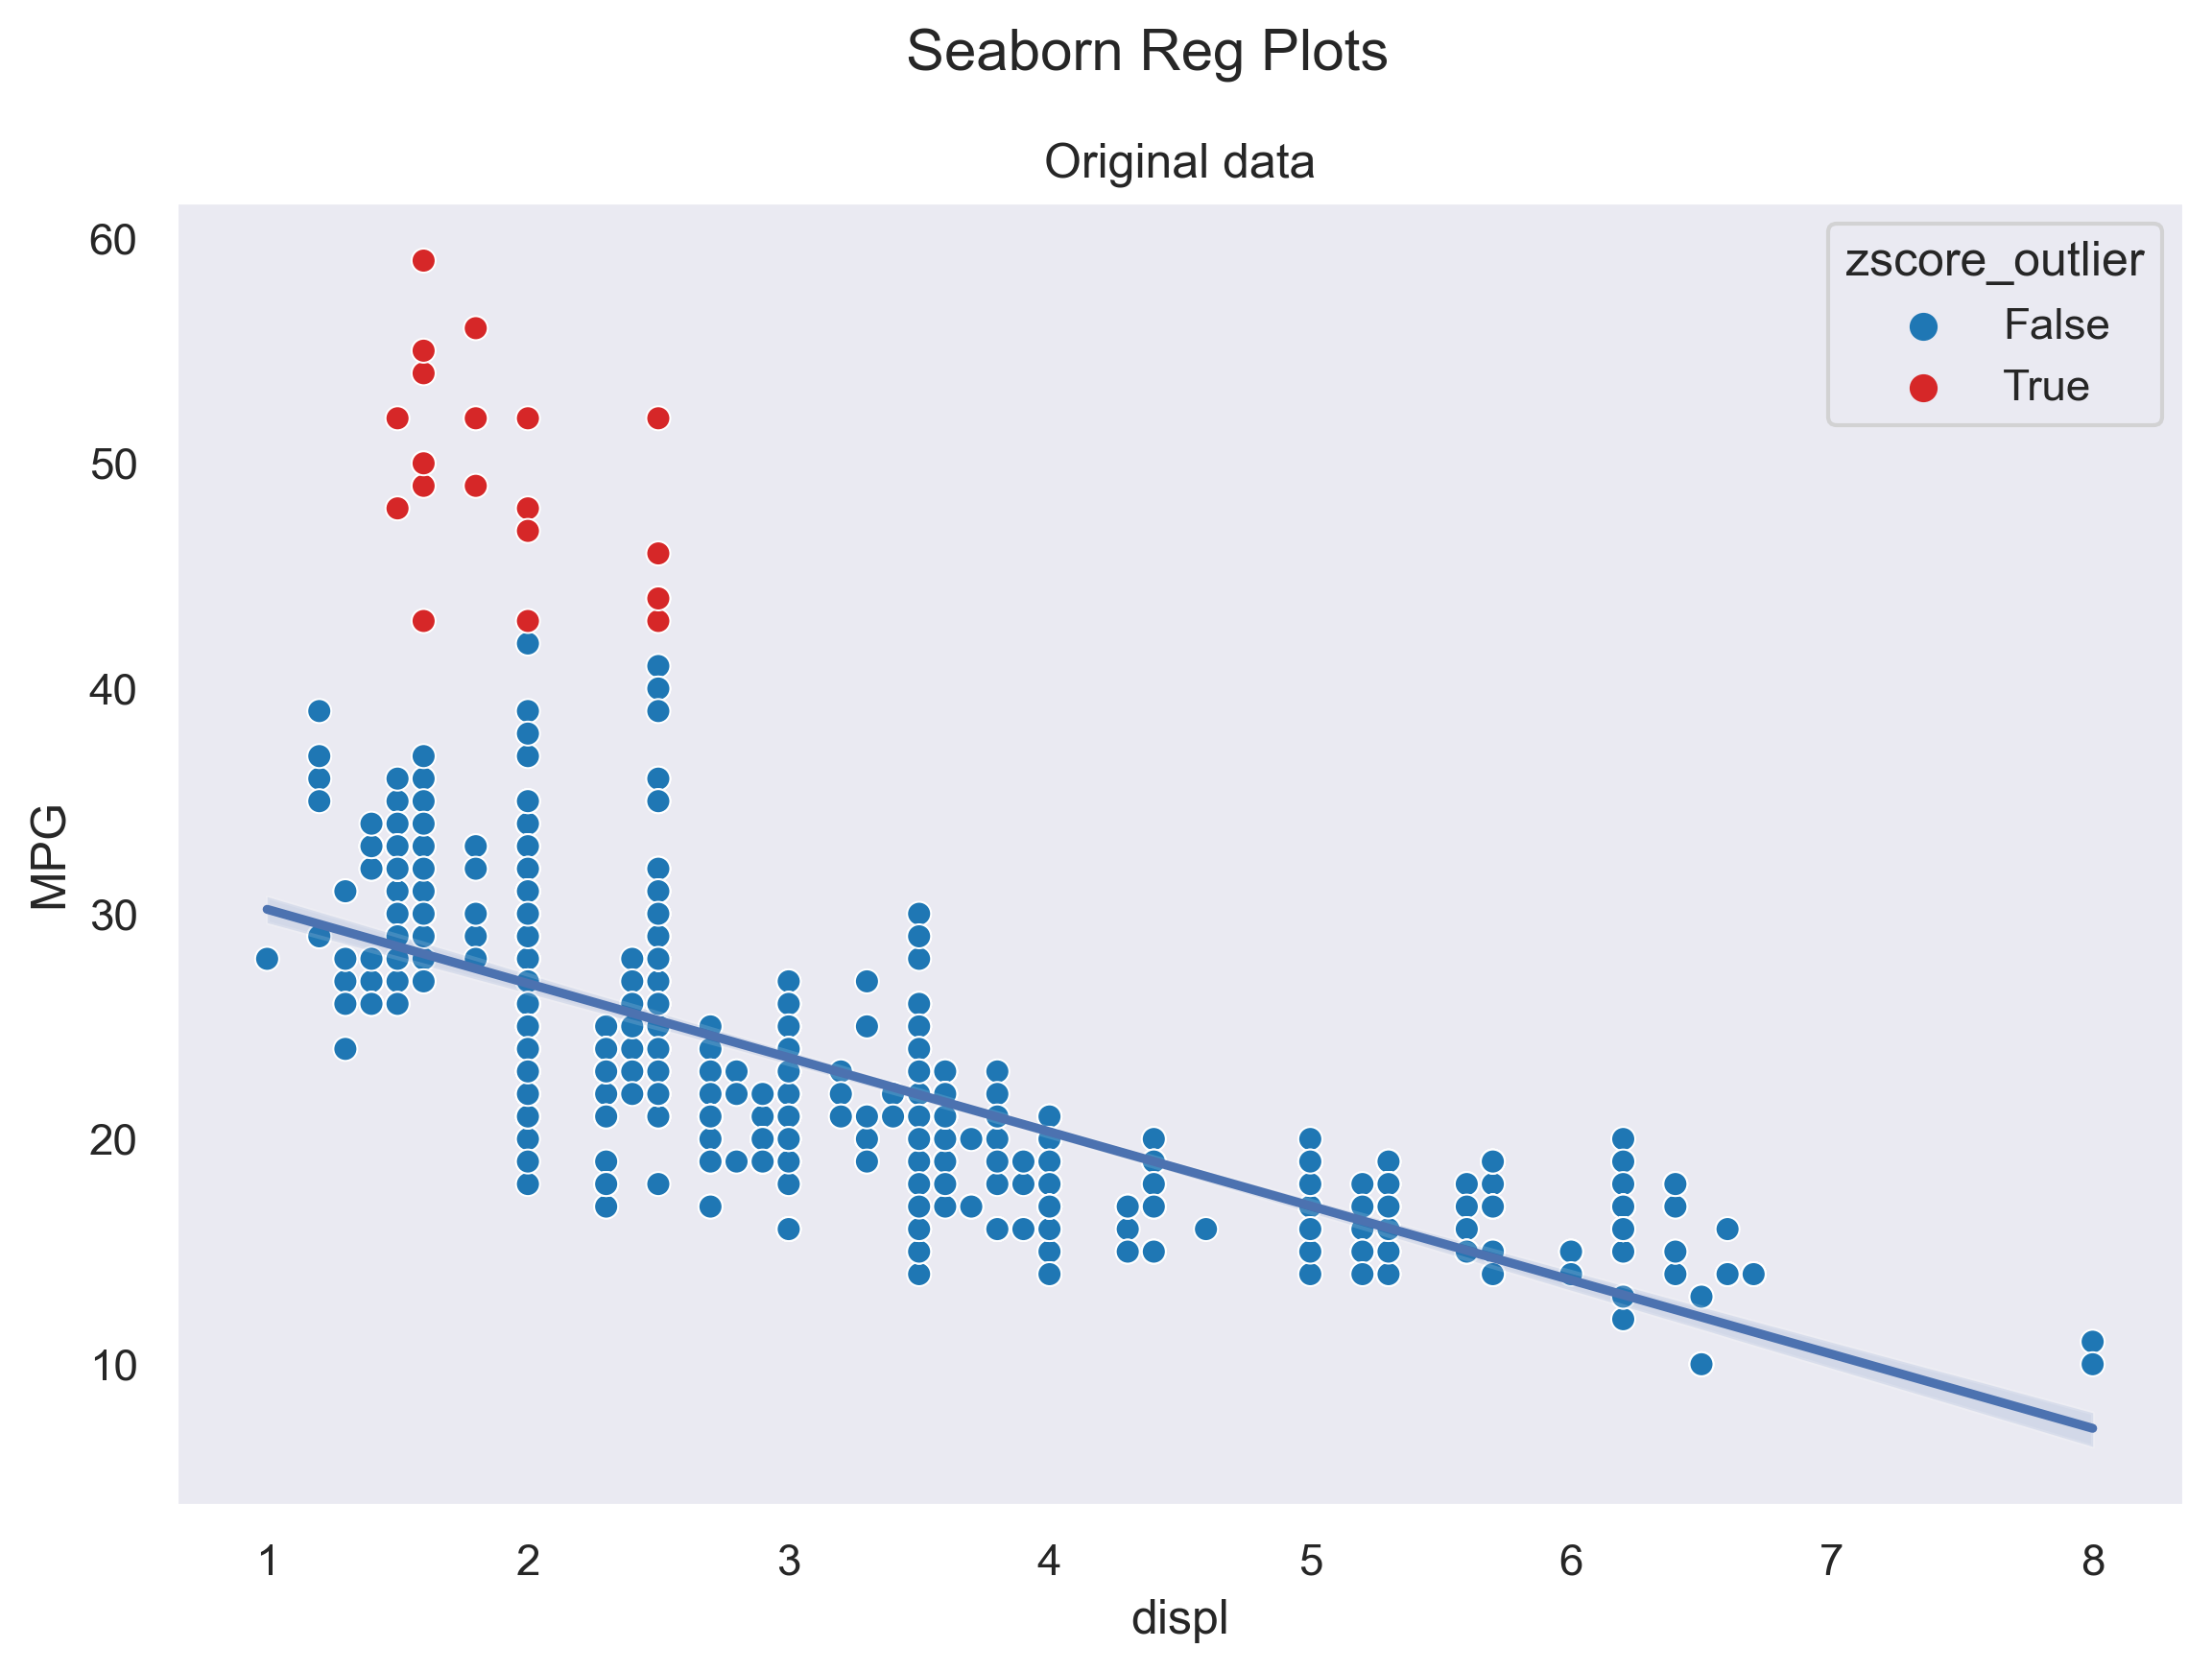

In [19]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(9,6), dpi=300)
fig.suptitle('Seaborn Reg Plots')
# set palette 
palette = {False:"tab:blue",
           True:"tab:red"}
sns.scatterplot(data=data, x="displ", y="MPG", ax=ax1, palette=palette, hue=data.zscore_outlier)
sns.regplot(data=data, x="displ", y="MPG", ax=ax1, scatter=False)
ax1.set_title("Original data")
# sns.scatterplot(data=data_o, x="displ", y="MPG", ax=ax2, palette=palette, hue=data_o.zscore_outlier)
# sns.regplot(data=data_o, x="displ", y="MPG", ax=ax2, scatter=False)
# ax2.set_title("Extreme Outlier Added")

In [20]:
data_4cyl = data[data.cyl==4]
data_4cyl_removed = data_4cyl[data_4cyl.zscore_outlier==False]

Text(0.5, 1.0, 'Original data')

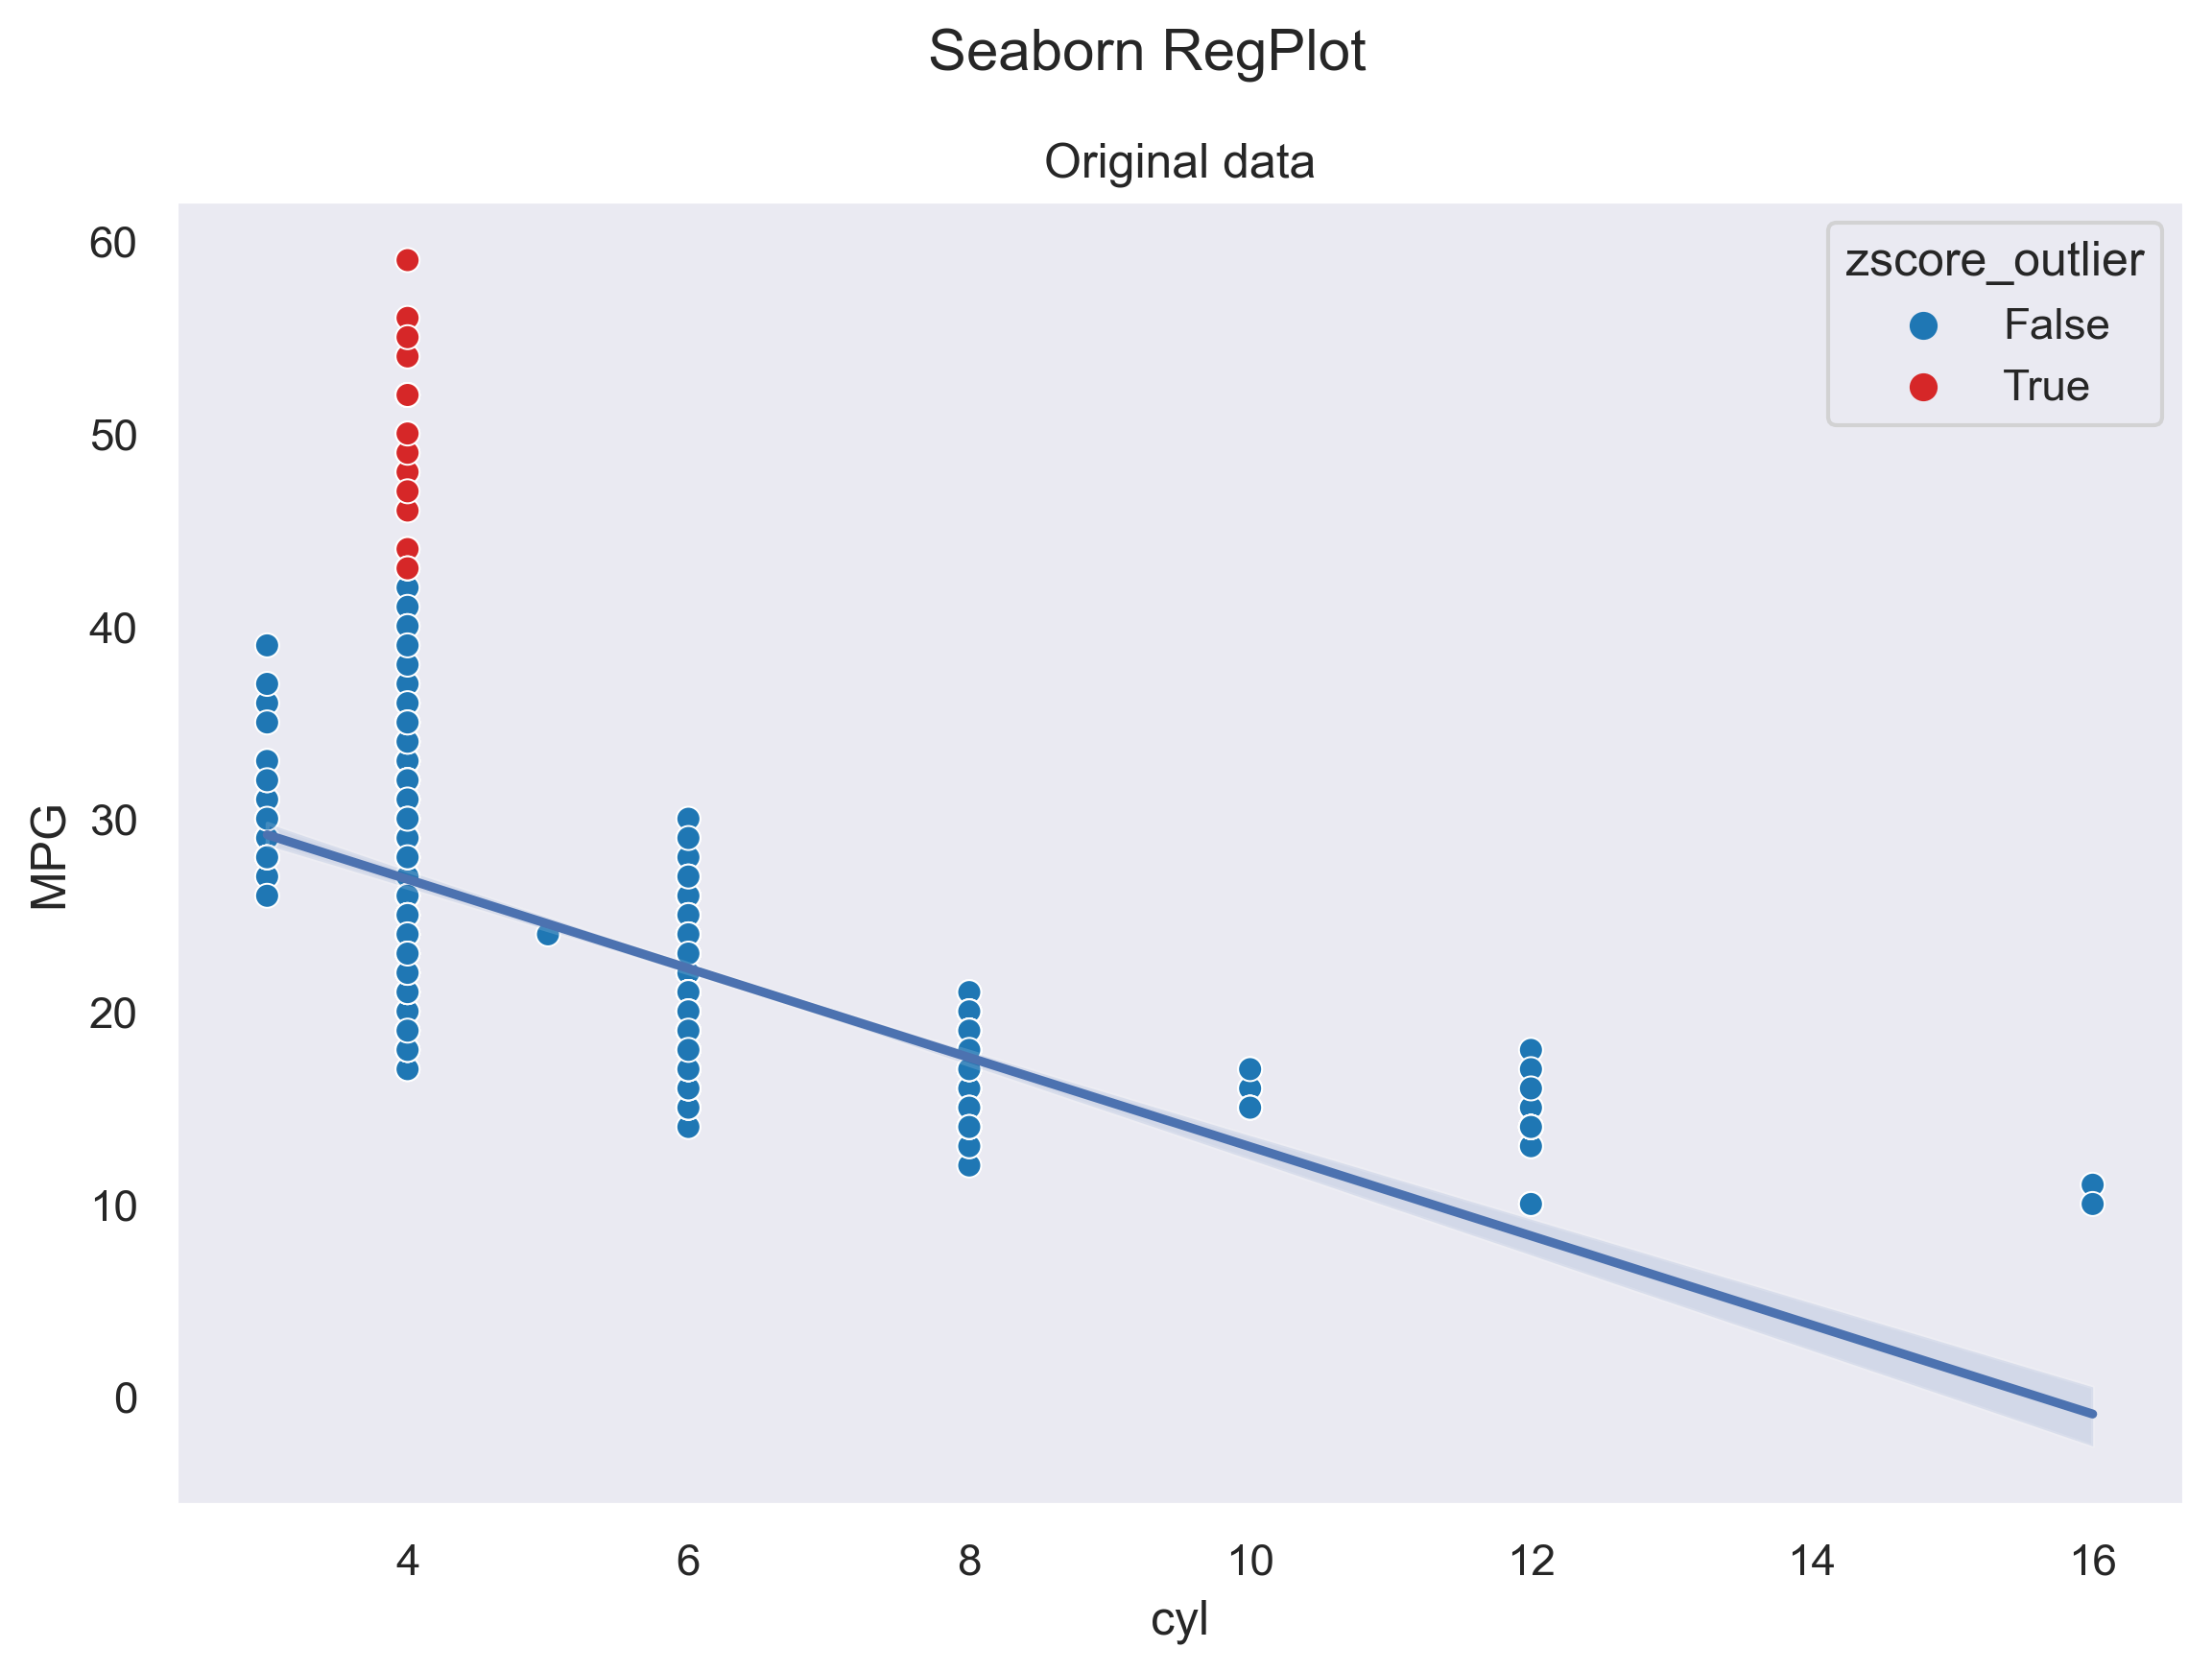

In [21]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(9,6), dpi=300, sharey=True)
fig.suptitle('Seaborn RegPlot')
# set palette 
palette = {False:"tab:blue",
           True:"tab:red"}

sns.scatterplot(data=data, x="cyl", y="MPG", ax=ax1, palette=palette, hue=data.zscore_outlier)
sns.regplot(data=data, x="cyl", y="MPG", ax=ax1, scatter=False)
ax1.set_title("Original data")

# sns.scatterplot(data=data_removed, x="cyl", y="MPG", ax=ax2, palette=palette, hue=data_removed.zscore_outlier)
# sns.regplot(data=data_removed, x="cyl", y="MPG", ax=ax2, scatter=False)
# ax2.set_title("Original data - Outliers removed")

Code for reference diagrams on IQR and IQR relationship to Normal Distribution
Source:
https://github.com/mGalarnyk/Python_Tutorials/blob/master/Statistics/boxplot/box_plot.ipynb

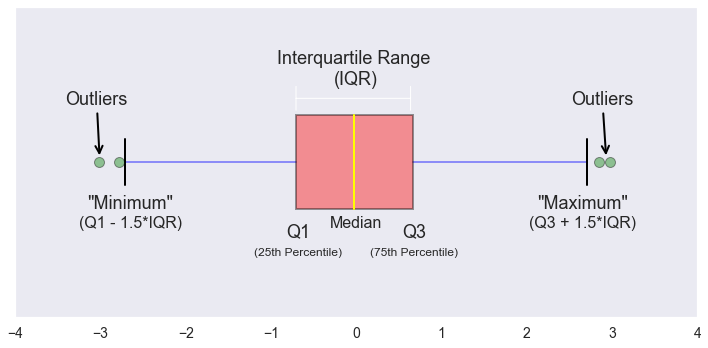

In [22]:
np.random.seed(916170)

# connection path is here: https://stackoverflow.com/questions/6146290/plotting-a-line-over-several-graphs
mu, sigma = 0, 1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(10, 5))

# rectangular box plot
bplot = axes.boxplot(s,
                vert=False,
                patch_artist=True, 
                showfliers=True, # This would show outliers (the remaining .7% of the data)
                positions = [0],
                boxprops = dict(linestyle='--', linewidth=2, color='Black', facecolor = 'red', alpha = .4),
                medianprops = dict(linestyle='-', linewidth=2, color='Yellow'),
                whiskerprops = dict(linestyle='-', linewidth=2, color='Blue', alpha = .4),
                capprops = dict(linestyle='-', linewidth=2, color='Black'),
                flierprops = dict(marker='o', markerfacecolor='green', markersize=10,
                  linestyle='none', alpha = .4),
                widths = .3,
                zorder = 1)   

axes.set_xlim(-4, 4)
plt.xticks(fontsize = 14)

axes.set_yticks([])
axes.annotate(r'',
            xy=(-.73, .205), xycoords='data',
            xytext=(.66, .205), textcoords='data',
            arrowprops=dict(arrowstyle="|-|",
                            connectionstyle="arc3")
            );

axes.text(0, .25, "Interquartile Range \n(IQR)",  horizontalalignment='center', fontsize=18)
axes.text(0, -.21, r"Median", horizontalalignment='center', fontsize=16);
axes.text(2.65, -.15, "\"Maximum\"", horizontalalignment='center', fontsize=18);
axes.text(-2.65, -.15, "\"Minimum\"", horizontalalignment='center', fontsize=18);
axes.text(-.68, -.24, r"Q1", horizontalalignment='center', fontsize=18);
axes.text(-2.65, -.21, r"(Q1 - 1.5*IQR)", horizontalalignment='center', fontsize=16);
axes.text(.6745, -.24, r"Q3", horizontalalignment='center', fontsize=18);
axes.text(.6745, -.30, r"(75th Percentile)", horizontalalignment='center', fontsize=12);
axes.text(-.68, -.30, r"(25th Percentile)", horizontalalignment='center', fontsize=12);
axes.text(2.65, -.21, r"(Q3 + 1.5*IQR)", horizontalalignment='center', fontsize=16);

axes.annotate('Outliers', xy=(2.93,0.015), xytext=(2.52,0.20), fontsize = 18,
            arrowprops={'arrowstyle': '->', 'color': 'black', 'lw': 2},
            va='center');

axes.annotate('Outliers', xy=(-3.01,0.015), xytext=(-3.41,0.20), fontsize = 18,
            arrowprops={'arrowstyle': '->', 'color': 'black', 'lw': 2},
            va='center');

fig.tight_layout()
# fig.savefig('images/simple_boxplot.png', dpi = 2000)

In [24]:


def normalProbabilityDensity(x):
    constant = 1.0 / np.sqrt(2*np.pi)
    return(constant * np.exp((-x**2) / 2.0) )

#Integrate PDF from -.6745 to .6745
result_n67_67, _ = quad(normalProbabilityDensity, -.6745, .6745, limit = 1000)

# Integrate PDF from -2.698 to -.6745
result_n2698_67, _ = quad(normalProbabilityDensity, -2.698, -.6745, limit = 1000)

# Integrate PDF from .6745 to 2.698
result_67_2698, _ = quad(normalProbabilityDensity, .6745, 2.698, limit = 1000)

# Integrate PDF from 2.698 to positive infinity
result_2698_inf, _ = quad(normalProbabilityDensity, 2.698, np.inf, limit = 1000)

# Integrate PDF from negative infinity to -2.698
result_ninf_n2698, _ = quad(normalProbabilityDensity, np.NINF, -2.698, limit = 1000)

C:\Users\ronbe\AppData\Local\Temp/ipykernel_22652/4067129293.py:156: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(xTickLabels, fontsize = 14)
C:\Users\ronbe\AppData\Local\Temp/ipykernel_22652/4067129293.py:157: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(xTickLabels, fontsize = 14)
C:\Users\ronbe\AppData\Local\Temp/ipykernel_22652/4067129293.py:160: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_yticklabels(yTickLabels, fontsize = 14)


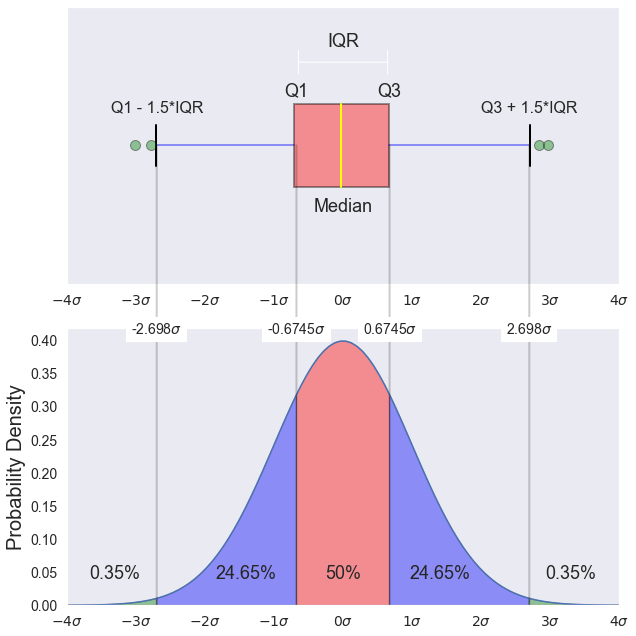

In [25]:
np.random.seed(916170)

# connection path is here: https://stackoverflow.com/questions/6146290/plotting-a-line-over-several-graphs
mu, sigma = 0, 1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)

fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(9, 9))

# rectangular box plot
bplot = axes[0].boxplot(s,
                vert=False,
                patch_artist=True, 
                showfliers=True, # This would show outliers (the remaining .7% of the data)
                positions = [0],
                boxprops = dict(linestyle='--', linewidth=2, color='Black', facecolor = 'red', alpha = .4),
                medianprops = dict(linestyle='-', linewidth=2, color='Yellow'),
                whiskerprops = dict(linestyle='-', linewidth=2, color='Blue', alpha = .4),
                capprops = dict(linestyle='-', linewidth=2, color='Black'),
                flierprops = dict(marker='o', markerfacecolor='green', markersize=10,
                  linestyle='none', alpha = .4),
                widths = .3,
                zorder = 1)   



axes[0].set_xlim(-4, 4)
axes[0].set_yticks([])
x = np.linspace(-4, 4, num = 100)
constant = 1.0 / np.sqrt(2*np.pi)
pdf_normal_distribution = constant * np.exp((-x**2) / 2.0)

axes[0].annotate(r'',
            xy=(-.6745, .30), xycoords='data',
            xytext=(.6745, .30), textcoords='data',
            arrowprops=dict(arrowstyle="|-|",
                            connectionstyle="arc3")
            );

axes[0].text(0, .36, r"IQR",  horizontalalignment='center', fontsize=18)
axes[0].text(0, -.24, r"Median", horizontalalignment='center', fontsize=18);
axes[0].text(-.6745, .18, r"Q1", horizontalalignment='center', fontsize=18);
axes[0].text(-2.698, .12, r"Q1 - 1.5*IQR", horizontalalignment='center', fontsize=16);
axes[0].text(.6745, .18, r"Q3", horizontalalignment='center', fontsize=18);
axes[0].text(2.698, .12, r"Q3 + 1.5*IQR", horizontalalignment='center', fontsize=16);

axes[1].plot(x, pdf_normal_distribution, zorder= 2)
axes[1].set_xlim(-4, 4)
axes[1].set_ylim(0)
axes[1].set_ylabel('Probability Density', size = 20)

##############################
# lower box
con = ConnectionPatch(xyA=(-.6745, 0), xyB=(-.6745, 0),
    coordsA="data", coordsB="data", axesA=axes[1], axesB=axes[0],
    arrowstyle="-", linewidth=2, color="black", zorder = 2, alpha = .2)
axes[1].add_artist(con)

# upper box
con = ConnectionPatch(xyA=(.6745, 0), xyB=(.6745, 0),
    coordsA="data", coordsB="data", axesA=axes[1], axesB=axes[0],
    arrowstyle="-", linewidth=2, color="black", zorder = 2, alpha = .2)
axes[1].add_artist(con)

# lower whisker
con = ConnectionPatch(xyA=(-2.698, 0), xyB=(-2.698, 0),
    coordsA="data", coordsB="data", axesA=axes[1], axesB=axes[0],
    arrowstyle="-", linewidth=2, color="black", zorder = 2, alpha = .2)
axes[1].add_artist(con)

# upper whisker
con = ConnectionPatch(xyA=(2.698, 0), xyB=(2.698, 0),
    coordsA="data", coordsB="data", axesA=axes[1], axesB=axes[0],
    arrowstyle="-", linewidth=2, color="black", zorder = 2, alpha = .2)
axes[1].add_artist(con)

# Make the shaded center region to represent integral
a, b = -.6745, .6745
ix = np.linspace(a, b)
iy = normalProbabilityDensity(ix)
verts = [(-.6745, 0)] + list(zip(ix, iy)) + [(.6745, 0)]
poly = Polygon(verts, facecolor='red', edgecolor='0.2', alpha = .4)
axes[1].add_patch(poly)
axes[1].text(0, .04, r'{0:.0f}%'.format(result_n67_67*100),
         horizontalalignment='center', fontsize=18)

##############################
a, b = -2.698, -.6745# integral limits

# Make the shaded region
ix = np.linspace(a, b)
iy = normalProbabilityDensity(ix)
verts = [(a, 0)] + list(zip(ix, iy)) + [(b, 0)]
poly = Polygon(verts, facecolor='blue', edgecolor='0.2', alpha = .4)
axes[1].add_patch(poly);
axes[1].text(-1.40, .04, r'{0:.2f}%'.format(result_n2698_67*100),
         horizontalalignment='center', fontsize=18);

##############################
a, b = .6745, 2.698 # integral limits

# Make the shaded region
ix = np.linspace(a, b)
iy = normalProbabilityDensity(ix)
verts = [(a, 0)] + list(zip(ix, iy)) + [(b, 0)]
poly = Polygon(verts, facecolor='blue', edgecolor='0.2', alpha = .4)
axes[1].add_patch(poly);
axes[1].text(1.40, .04, r'{0:.2f}%'.format(result_67_2698*100),
         horizontalalignment='center', fontsize=18);

##############################
a, b = 2.698, 4 # integral limits

# Make the shaded region
ix = np.linspace(a, b)
iy = normalProbabilityDensity(ix)
verts = [(a, 0)] + list(zip(ix, iy)) + [(b, 0)]
poly = Polygon(verts, facecolor='green', edgecolor='0.2', alpha = .4)
axes[1].add_patch(poly);
axes[1].text(3.3, .04, r'{0:.2f}%'.format(result_2698_inf*100),
         horizontalalignment='center', fontsize=18);

##############################
a, b = -4, -2.698 # integral limits

# Make the shaded region
ix = np.linspace(a, b)
iy = normalProbabilityDensity(ix)
verts = [(a, 0)] + list(zip(ix, iy)) + [(b, 0)]
poly = Polygon(verts, facecolor='green', edgecolor='0.2', alpha = .4)
axes[1].add_patch(poly);
axes[1].text(-3.3, .04, r'{0:.2f}%'.format(result_ninf_n2698*100),
         horizontalalignment='center', fontsize=18);

##############################
xTickLabels = [r'$-4\sigma$',
               r'$-3\sigma$',
               r'$-2\sigma$',
               r'$-1\sigma$',
               r'$0\sigma$',
               r'$1\sigma$',
               r'$2\sigma$',
               r'$3\sigma$',
               r'$4\sigma$']

yTickLabels = ['0.00',
               '0.05',
               '0.10',
               '0.15',
               '0.20',
               '0.25',
               '0.30',
               '0.35',
               '0.40']

# Make both x axis into standard deviations
axes[0].set_xticklabels(xTickLabels, fontsize = 14)
axes[1].set_xticklabels(xTickLabels, fontsize = 14)

# Only the PDF needs y ticks
axes[1].set_yticklabels(yTickLabels, fontsize = 14)

##############################
# Add -2.698, -.6745, .6745, 2.698 text without background
axes[1].text(-.6745,.41, r'{0:.4f}'.format(-.6745) + '$\sigma$', horizontalalignment='center', fontsize=14,
            bbox={'facecolor':'white', 'edgecolor':'none', 'pad':5});

axes[1].text(.6745, .410, r'{0:.4f}'.format(.6745) + '$\sigma$', horizontalalignment='center', fontsize=14,
            bbox={'facecolor':'white', 'edgecolor':'none', 'pad':5});

axes[1].text(-2.698, .410, r'{0:.3f}'.format(-2.698) + '$\sigma$', horizontalalignment='center', fontsize=14,
            bbox={'facecolor':'white', 'edgecolor':'none', 'pad':5});

axes[1].text(2.698, .410, r'{0:.3f}'.format(2.698) + '$\sigma$', horizontalalignment='center', fontsize=14,
            bbox={'facecolor':'white', 'edgecolor':'none', 'pad':5});

fig.tight_layout()